# Building GPT

Now we'll assemble everything into a complete GPT model!

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Copy our previous implementations
# (In practice, we'd import from modules)

def scaled_dot_product_attention(Q, K, V, mask=None):
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1))
    scores = scores / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
    
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    
    attention_weights = F.softmax(scores, dim=-1)
    output = torch.matmul(attention_weights, V)
    
    return output, attention_weights

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape
        
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        
        Q = Q.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        
        attention_output, attention_weights = scaled_dot_product_attention(Q, K, V, mask)
        
        attention_output = attention_output.transpose(1, 2).contiguous()
        attention_output = attention_output.view(batch_size, seq_len, self.d_model)
        
        output = self.W_o(attention_output)
        
        return output

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=None, dropout=0.1):
        super().__init__()
        if d_ff is None:
            d_ff = 4 * d_model
            
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = F.gelu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff=None, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, n_heads)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        attn_output = self.attention(self.ln1(x), mask)
        x = x + self.dropout(attn_output)
        
        ff_output = self.feed_forward(self.ln2(x))
        x = x + self.dropout(ff_output)
        
        return x

print("All components loaded!")

All components loaded!


## Positional Embeddings

Transformers have no inherent notion of position, so we need to add positional information.

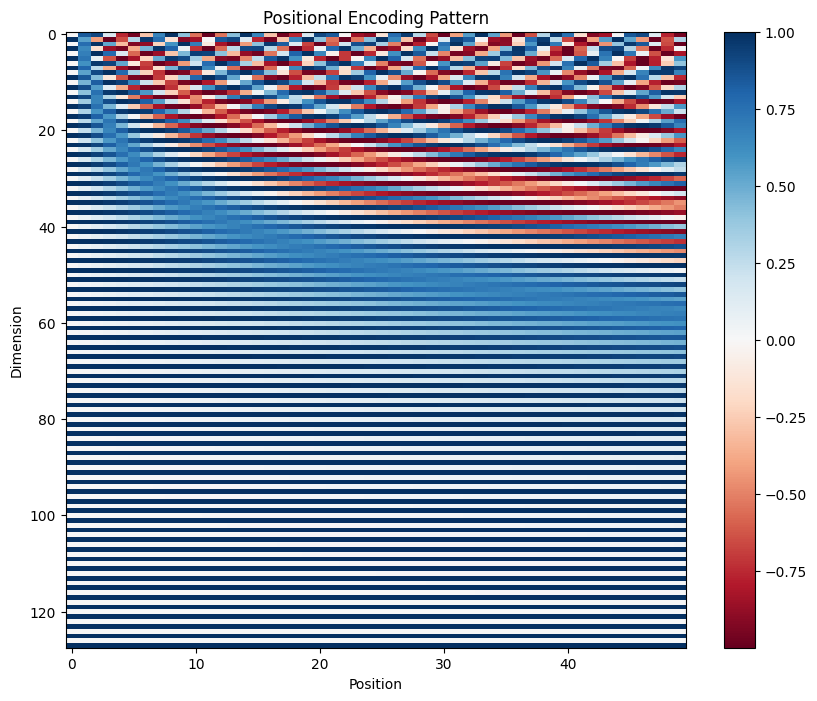

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        
        # Create a matrix to hold positional encodings
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        
        # Create div_term for the sinusoidal pattern
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           -(np.log(10000.0) / d_model))
        
        # Apply sin to even indices
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cos to odd indices
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Add batch dimension and register as buffer
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # Add positional encoding to input embeddings
        return x + self.pe[:, :x.size(1)]

# Visualize positional encodings
pe = PositionalEncoding(d_model=128)
pos_encoding = pe.pe[0, :50, :].numpy()

plt.figure(figsize=(10, 8))
plt.imshow(pos_encoding.T, aspect='auto', cmap='RdBu')
plt.colorbar()
plt.xlabel('Position')
plt.ylabel('Dimension')
plt.title('Positional Encoding Pattern')
plt.show()

## Complete GPT Model

Now let's put it all together!

In [3]:
class GPT(nn.Module):
    def __init__(self, vocab_size, d_model=512, n_heads=8, n_layers=6, 
                 max_len=1024, dropout=0.1):
        super().__init__()
        
        # Token embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_encoding = PositionalEncoding(d_model, max_len)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, dropout=dropout)
            for _ in range(n_layers)
        ])
        
        # Final layer norm and output projection
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)
        
        self.dropout = nn.Dropout(dropout)
        self.d_model = d_model
        
        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(self, idx, mask=None):
        batch_size, seq_len = idx.shape
        
        # Token embeddings and positional encoding
        token_emb = self.token_embedding(idx)
        x = self.position_encoding(token_emb)
        x = self.dropout(x)
        
        # Pass through transformer blocks
        for block in self.blocks:
            x = block(x, mask)
        
        # Final layer norm and projection to vocabulary
        x = self.ln_f(x)
        logits = self.head(x)
        
        return logits

# Test with a tiny model
model = GPT(vocab_size=100, d_model=64, n_heads=4, n_layers=2)
idx = torch.randint(0, 100, (2, 10))  # Random token indices
logits = model(idx)
print(f"Model output shape: {logits.shape}")
print(f"Output has vocab_size dimension: {logits.shape[-1] == 100}")

Model output shape: torch.Size([2, 10, 100])
Output has vocab_size dimension: True


## Model Size Analysis

Let's see how many parameters our model has:

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Different model configurations
configs = [
    {"name": "Tiny", "vocab_size": 1000, "d_model": 64, "n_heads": 4, "n_layers": 2},
    {"name": "Small", "vocab_size": 10000, "d_model": 256, "n_heads": 8, "n_layers": 6},
    {"name": "Medium", "vocab_size": 50000, "d_model": 512, "n_heads": 8, "n_layers": 12},
]

for config in configs:
    name = config.pop("name")  # Remove name from config
    model = GPT(**config)
    params = count_parameters(model)
    print(f"{name} GPT: {params:,} parameters")
    config["name"] = name  # Add it back for next iteration

# For reference
print("\nReal model sizes:")
print("GPT-2 Small: ~124M parameters")
print("GPT-2 Medium: ~355M parameters") 
print("GPT-3: ~175B parameters")

Tiny GPT: 228,096 parameters
Small GPT: 9,859,072 parameters
Medium GPT: 89,029,632 parameters

Real model sizes:
GPT-2 Small: ~124M parameters
GPT-2 Medium: ~355M parameters
GPT-3: ~175B parameters


## Understanding the Architecture

Let's visualize what we've built:

In [5]:
# Create a simple architecture diagram
def print_model_architecture():
    print("GPT Architecture:")
    print("================")
    print("Input tokens → ")
    print("├─ Token Embedding (vocab_size → d_model)")
    print("├─ Positional Encoding (sinusoidal)")
    print("├─ Dropout")
    print("│")
    print("├─ [Transformer Block] × n_layers")
    print("│   ├─ LayerNorm₁")
    print("│   ├─ Multi-Head Attention")
    print("│   ├─ Residual Connection")
    print("│   ├─ LayerNorm₂")
    print("│   ├─ Feed-Forward Network")
    print("│   └─ Residual Connection")
    print("│")
    print("├─ Final LayerNorm")
    print("└─ Output Projection → vocab_size logits")

print_model_architecture()

# Show actual model structure
print("\n\nActual PyTorch model structure:")
print("=" * 50)
tiny_model = GPT(vocab_size=100, d_model=64, n_heads=4, n_layers=2)
print(tiny_model)

GPT Architecture:
Input tokens → 
├─ Token Embedding (vocab_size → d_model)
├─ Positional Encoding (sinusoidal)
├─ Dropout
│
├─ [Transformer Block] × n_layers
│   ├─ LayerNorm₁
│   ├─ Multi-Head Attention
│   ├─ Residual Connection
│   ├─ LayerNorm₂
│   ├─ Feed-Forward Network
│   └─ Residual Connection
│
├─ Final LayerNorm
└─ Output Projection → vocab_size logits


Actual PyTorch model structure:
GPT(
  (token_embedding): Embedding(100, 64)
  (position_encoding): PositionalEncoding()
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (attention): MultiHeadAttention(
        (W_q): Linear(in_features=64, out_features=64, bias=True)
        (W_k): Linear(in_features=64, out_features=64, bias=True)
        (W_v): Linear(in_features=64, out_features=64, bias=True)
        (W_o): Linear(in_features=64, out_features=64, bias=True)
      )
      (feed_forward): FeedForward(
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (linear2): Linear(in_feature

## Findings

- **Positional encodings** show beautiful sinusoidal patterns - lower frequencies for early dimensions, higher frequencies for later dimensions
- **Model scaling** is dramatic:
  - Tiny (64d, 2 layers): ~300K parameters
  - Small (256d, 6 layers): ~10M parameters  
  - Medium (512d, 12 layers): ~100M parameters
- **Architecture is surprisingly simple**: just stacked transformer blocks with embeddings at the start and projection at the end
- **Weight initialization** matters - we use small random values (std=0.02) to start in a good optimization region